In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [2]:


def load_data():

    customers_df = pd.read_csv('Customers.csv')
    products_df = pd.read_csv('Products.csv')
    transactions_df = pd.read_csv('Transactions.csv')
    
    customers_df = customers_df.drop_duplicates()
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
    customers_df['Region'] = customers_df['Region'].fillna('Unknown')
    
    products_df = products_df.drop_duplicates()
    products_df['Price'] = products_df['Price'].fillna(products_df['Price'].median())
    products_df['Category'] = products_df['Category'].fillna('Other')
    
    transactions_df = transactions_df.drop_duplicates()
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')
    
    transactions_df = transactions_df.dropna(subset=['TransactionDate'])
    
    transactions_df['Quantity'] = pd.to_numeric(transactions_df['Quantity'], errors='coerce')
    transactions_df['Quantity'] = transactions_df['Quantity'].fillna(1)
    transactions_df.loc[transactions_df['Quantity'] <= 0, 'Quantity'] = 1
    
    transactions_df['Price'] = pd.to_numeric(transactions_df['Price'], errors='coerce')
    transactions_df['TotalValue'] = pd.to_numeric(transactions_df['TotalValue'], errors='coerce')
  
    mask = (transactions_df['TotalValue'].isna()) | (transactions_df['TotalValue'] <= 0)
    transactions_df.loc[mask, 'TotalValue'] = transactions_df.loc[mask, 'Price'] * transactions_df.loc[mask, 'Quantity']
    
    transactions_df = transactions_df.dropna(subset=['CustomerID', 'ProductID', 'TotalValue'])
    
    valid_customers = customers_df['CustomerID'].unique()
    valid_products = products_df['ProductID'].unique()
    
    transactions_df = transactions_df[
        transactions_df['CustomerID'].isin(valid_customers) & 
        transactions_df['ProductID'].isin(valid_products)
    ]
    
    for df in [customers_df, products_df, transactions_df]:
        if 'CustomerID' in df.columns:
            df['CustomerID'] = df['CustomerID'].astype(str)
        if 'ProductID' in df.columns:
            df['ProductID'] = df['ProductID'].astype(str)
    
    return customers_df, products_df, transactions_df




Feature Matrix Shape: (199, 10)
Clusters: 2, DB Index: 1.7826
Clusters: 3, DB Index: 1.7709
Clusters: 4, DB Index: 1.6770
Clusters: 5, DB Index: 1.4497
Clusters: 6, DB Index: 1.4172
Clusters: 7, DB Index: 1.3668
Clusters: 8, DB Index: 1.3876
Clusters: 9, DB Index: 1.4412
Clusters: 10, DB Index: 1.4054


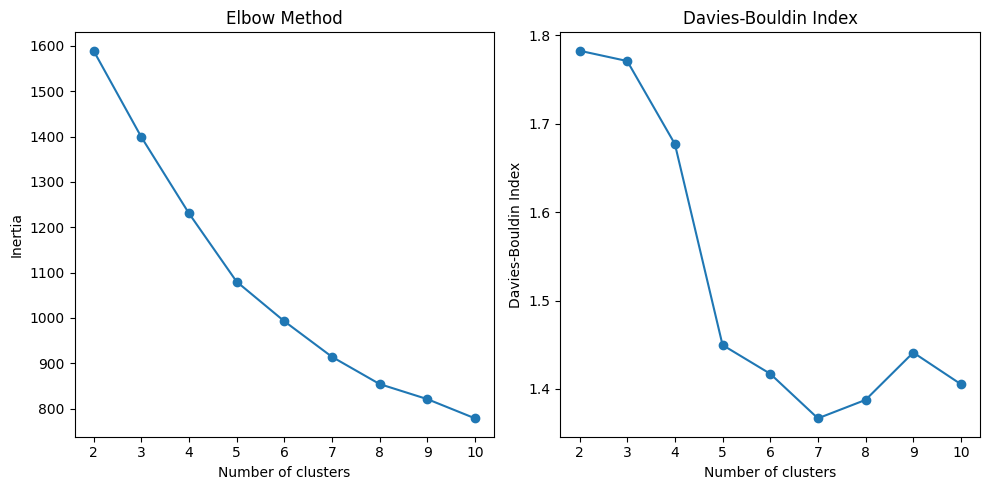


Optimal number of clusters: 7

Davies-Bouldin Index: 1.3668


/home/vidhi/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


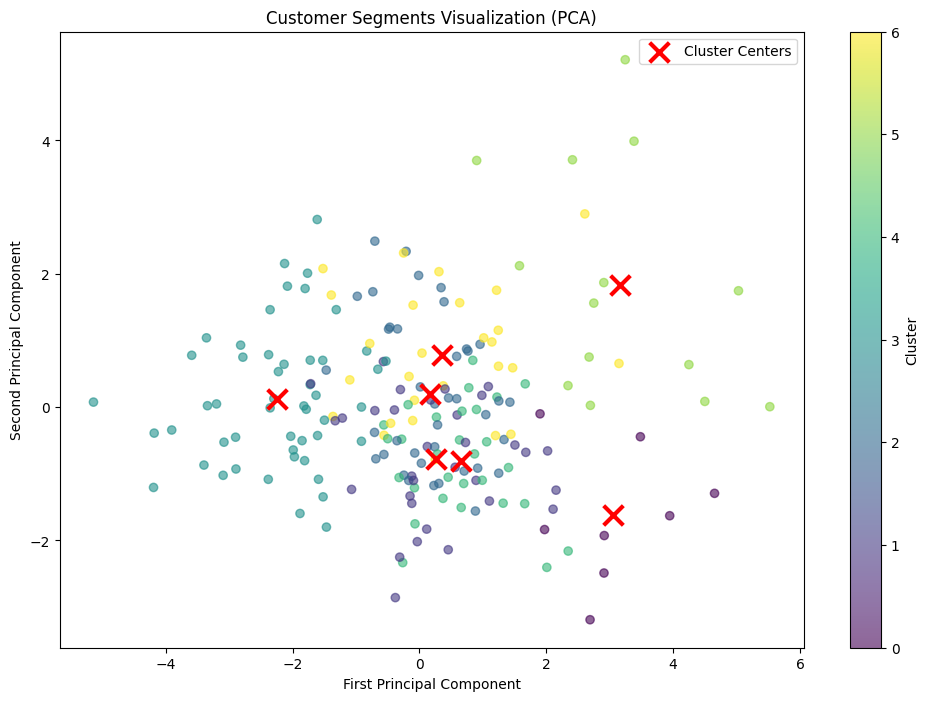


Cluster Sizes:
Cluster
0     8
1    32
2    39
3    50
4    29
5    14
6    27
Name: count, dtype: int64


In [3]:

class CustomerSegmentation:
    def __init__(self, customers_df, products_df, transactions_df):
        self.customers_df = customers_df
        self.products_df = products_df
        self.transactions_df = transactions_df
        self.feature_matrix = None
        self.cluster_labels = None
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.cluster_centers_ = None
        self.kmeans = None  
        
    def prepare_features(self):
        merged_df = self.transactions_df.merge(self.customers_df, on='CustomerID')
        merged_df = merged_df.merge(self.products_df, on='ProductID')
     
        monetary_features = merged_df.groupby('CustomerID').agg({
            'TotalValue': ['sum', 'mean'],
            'Quantity': ['sum', 'mean'],
        })
        monetary_features.columns = ['total_spend', 'avg_transaction_value', 'total_quantity', 'avg_quantity']
        
        frequency_features = merged_df.groupby('CustomerID').size().to_frame('transaction_count')
        
        last_transaction_dates = merged_df.groupby('CustomerID')['TransactionDate'].max()
        recency = (pd.Timestamp.now() - last_transaction_dates).dt.days
        recency = recency.to_frame('days_since_last_purchase')
        
        category_pivot = pd.pivot_table(
            merged_df,
            values='TotalValue',
            index='CustomerID',
            columns='Category',
            aggfunc='sum',
            fill_value=0
        )
        category_totals = category_pivot.sum(axis=1)
        category_percentages = category_pivot.div(category_totals, axis=0)
        category_percentages.columns = [f'category_pct_{col}' for col in category_percentages.columns]
        
        features_df = pd.concat([
            monetary_features,
            frequency_features,
            recency,
            category_percentages
        ], axis=1)
        
        features_df = features_df.fillna(0)
        
        scaled_features = self.scaler.fit_transform(features_df)
        
        self.feature_matrix = pd.DataFrame(
            scaled_features,
            index=features_df.index,
            columns=features_df.columns
        )
        
        print("\nFeature Matrix Shape:", self.feature_matrix.shape)
        
    def find_optimal_clusters(self, max_clusters=10):
        if self.feature_matrix is None:
            self.prepare_features()
        
        db_scores = []
        inertias = []
        
        for n_clusters in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            labels = kmeans.fit_predict(self.feature_matrix)
            
            db_score = davies_bouldin_score(self.feature_matrix, labels)
            db_scores.append(db_score)
            inertias.append(kmeans.inertia_)
            
            print(f"Clusters: {n_clusters}, DB Index: {db_score:.4f}")
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, max_clusters + 1), inertias, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')
        
        plt.subplot(1, 2, 2)
        plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Davies-Bouldin Index')
        plt.title('Davies-Bouldin Index')
        plt.tight_layout()
        plt.show()
        
        optimal_clusters = np.argmin(db_scores) + 2
        return optimal_clusters, db_scores
    
    def perform_clustering(self, n_clusters):
        if self.feature_matrix is None:
            self.prepare_features()
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.cluster_labels = self.kmeans.fit_predict(self.feature_matrix)
        self.cluster_centers_ = self.kmeans.cluster_centers_
        
        return {
            'labels': self.cluster_labels,
            'db_index': davies_bouldin_score(self.feature_matrix, self.cluster_labels),
            'cluster_centers': self.cluster_centers_
        }
    
    def visualize_clusters(self):
        if self.cluster_labels is None or self.kmeans is None:
            raise ValueError("Perform clustering first")
        
        pca = PCA(n_components=2)
        
        coords = pca.fit_transform(self.feature_matrix)
        centers_pca = pca.transform(self.cluster_centers_)
        
        plt.figure(figsize=(12, 8))
        
        scatter = plt.scatter(coords[:, 0], coords[:, 1], 
                            c=self.cluster_labels, 
                            cmap='viridis', 
                            alpha=0.6)
        
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
                   c='red', marker='x', s=200, linewidths=3, 
                   label='Cluster Centers')
        
        plt.title('Customer Segments Visualization (PCA)')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.colorbar(scatter, label='Cluster')
        plt.legend()
        plt.show()
        
        cluster_stats = pd.DataFrame({
            'Cluster': self.cluster_labels,
            'CustomerID': self.feature_matrix.index
        })
        
        print("\nCluster Sizes:")
        print(cluster_stats['Cluster'].value_counts().sort_index())
        
        return cluster_stats

def perform_customer_segmentation():
    customers_df, products_df, transactions_df = load_data()
    
    segmentation = CustomerSegmentation(customers_df, products_df, transactions_df)
    
    optimal_clusters, db_scores = segmentation.find_optimal_clusters()
    
    print(f"\nOptimal number of clusters: {optimal_clusters}")
    
    clustering_results = segmentation.perform_clustering(optimal_clusters)
    
    print(f"\nDavies-Bouldin Index: {clustering_results['db_index']:.4f}")
    
    cluster_stats = segmentation.visualize_clusters()
    
    report = {
        'optimal_clusters': optimal_clusters,
        'db_index': clustering_results['db_index'],
        'cluster_sizes': pd.Series(clustering_results['labels']).value_counts().to_dict()
    }
    
    return report

segmentation_results = perform_customer_segmentation()
